In [7]:
import sys
from __future__ import division, print_function, absolute_import
sys.path.append('/home/ajss/notebooks/deep-learning-projects/')

from tqdm import tqdm
from rbm import RBM
from rbm_original import RBMOriginal
from cnn import ConvolutionalNetwork


from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Image
from tensorflow.python.ops import control_flow_ops
from utils import tile_raster_images
import IPython.display
import math
%matplotlib inline


(42000, 784)
(42000,)


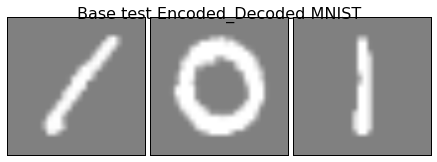

In [2]:
def next_batch(index,data,labels,batch_size=10):
    """Return the next `batch_size` examples from this data set."""
    total = data.shape[0]
    end = index + batch_size
    max_end =  max(0, index + batch_size - total)
    retData =  np.concatenate((data[index:end],data[:max_end]), axis=0)
    retlabel =  np.concatenate((labels[index:end],labels[:max_end]), axis=0)
    return retData,retlabel
def plot_gallery(title, images, n_col, n_row,image_shape = (28, 28)):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()   
    
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# read training data from CSV file 
dataTrain = pd.read_csv('./kaggle-mnist/train.csv')
images = dataTrain.iloc[:,1:].values
images = images.astype(np.float)
images = np.multiply(images, 1.0 / 255.0)

labels_flat = dataTrain[[0]].values.ravel()
labels_count = np.unique(labels_flat).shape[0]
# labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels_flat #dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)
print(images.shape)
print(labels.shape)
for i in range(1):
    batch_xs, batch_ys = next_batch(i*10, images,labels)
    plot_gallery('Base test Encoded_Decoded MNIST',batch_xs[:3],3,1)



In [3]:
# # read test data from CSV file 
# datatest = pd.read_csv('./kaggle-mnist/test.csv')
# imagestest = datatest.iloc[:,:].values
# imagestest = imagestest.astype(np.float)
# imagestest = np.multiply(imagestest, 1.0 / 255.0)


CNN as extractor and dimension reduction
---------

In [4]:

flags = tf.app.flags
FLAGS = flags.FLAGS
#flags.DEFINE_string('data_dir', '/home/ajsss/data_deep/', 'Directory for storing data')


WITH DROPOUT
-------

In [18]:

# Autoencoder
layers="conv2d-24-24-32-1,maxpool-2,conv2d-5-5-32-1,maxpool-2,full-256,full-2,softmax"

n_features = 784
n_classes = 784
original_shape = [28,28,1]
cnn = ConvolutionalNetwork(layers=layers,n_features=n_features,n_classes=n_classes,original_shape=original_shape,keep_prob=0.9
                           ,loss_func='mean_squared')


Building Convolutional layer with 1 input channels                      and 32 24x24 filters with stride 1
Building Max Pooling layer with size 2
Building Convolutional layer with 32 input channels                      and 32 5x5 filters with stride 1
Building Max Pooling layer with size 2
Building fully connected layer with 1568 in units                          and 256 out units
Building softmax layer with 2 in units and                      784 out units


In [19]:
# Train DBN
batch_size = 30
epoch = 200
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

interactions = int(math.floor(X_train.shape[0]/batch_size))
print_times = 3
print('CNN')
for i in tqdm(range(epoch)):
    cost = 0.0
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, X_train,y_train,batch_size)
        cost += cnn.partial_fit(batch_xs,batch_xs)
    if i%math.floor(epoch/print_times)==0:
        print(i,'cost: ',cost)        
print(i,'cost: ',cost)



  0%|          | 0/200 [00:00<?, ?it/s]

CNN


  0%|          | 1/200 [00:22<1:13:27, 22.15s/it]

0 cost:  387.603699148


100%|██████████| 200/200 [1:13:17<00:00, 21.99s/it]

199 cost:  326.878534049


[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 ..., 
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


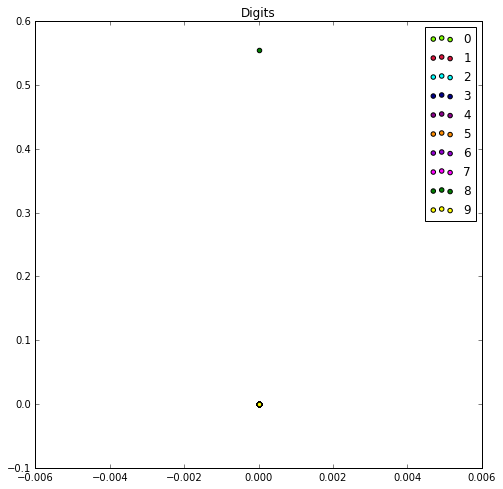

In [20]:
X_transformed = cnn.transform(X_test)
print(X_transformed)
colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")


PCA
-----

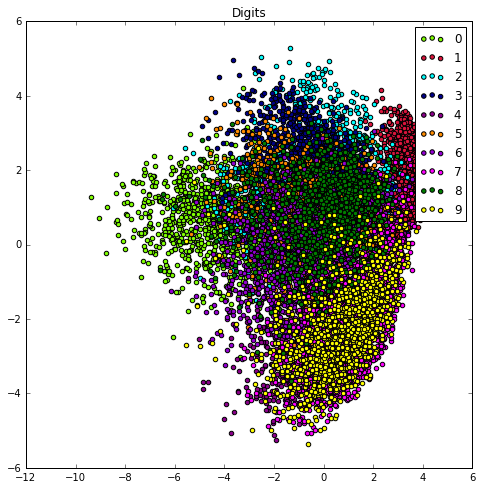

In [29]:
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
pca = PCA(n_components=3).fit(X_train)
X_transformed = pca.transform(X_test)

colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")
